<a href="https://colab.research.google.com/github/shepai/BIORTC_Nigeria/blob/main/rnn_rdm_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Recurrent Neural Networks
==================================



## Settings



In [1]:
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rc("axes.spines", top=False, right=False)

golden_ratio = (5**.5 - 1) / 2
width = 5
height = width * golden_ratio

plt.rc("axes.spines", top=False, right=False)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams["figure.autolayout"] = True
plt.rcParams['lines.markersize'] = 5
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

## Imports



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [3]:
torch.manual_seed(2)
np.random.seed(2)

## 🧠 Dynamical RNNs



Let:

-   $ x_t $: feedforward input at time step $ t $
-   $ r_t $: rate at time $ t $
-   $ y_t $: output at time $ t $

$$
r_t = (1 - \frac{\delta t}{\tau}) r_{t-1} + \frac{\Delta t}{\tau} \mathcal{F}(W_{ih} x_t + b_{ih} + W_{hh} r_{t-1})
$$

$$
y_t = \mathcal{S}(W_{ho} r_t + b_o)
$$

In [4]:
class BioRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt=0.1, tau=1.0, sigma=0.1):
        super().__init__()
        # input layer
        self.wi = nn.Linear(input_size, hidden_size)
        # recurrent layer
        self.wrec = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        nn.init.xavier_uniform_(self.wrec)
        # output layer
        self.wo = nn.Linear(hidden_size, output_size)
        # non linearity
        self.nonlinearity = torch.tanh
        # time constant
        self.DT_TAU = dt / tau
        # variance of the noise
        self.sigma = sigma


    def update_dynamics(self, ff_inputs, rates, noise):
        # updating the recurrent inputs and rates
        rec_inputs = rates @ self.wrec.T # / rates.shape[-1]
        nonlinear = self.nonlinearity(self.wi(ff_inputs) + rec_inputs)
        # here we use the Euler-Murayama scheme
        rates = (1-self.DT_TAU) * rates + self.DT_TAU * nonlinear + torch.sqrt(torch.tensor(self.DT_TAU))* noise

        return rates, rec_inputs


    def forward(self, ff_inputs):
        # This is the main function of the class
        # ff_input is (n_trials, seq_len, input_size)
        # we create rates and rec_inputs are (n_trials, hidden_size)
        noise = self.sigma * torch.randn(ff_inputs.shape[0], self.wrec.shape[0])
        rec_inputs = torch.randn(ff_inputs.shape[0], self.wrec.shape[0])
        rates = self.nonlinearity(self.wi(ff_inputs[:, -1]) + rec_inputs)

        readout_list = []
        # for each step in the sequence we update the dynamics
        for step in range(ff_inputs.shape[1]):
            rates, rec_inputs = self.update_dynamics(ff_inputs[:, step], rates, noise)
            # compute the readout
            readout = self.wo(rates)
            # and save the readout
            readout_list.append(readout)

        readout_list = torch.stack(readout_list, dim=1)

        return readout_list

---



## Initializing the model



In [5]:
input_size = 1
hidden_size = 256
output_size = 1

model = BioRNNModel(input_size, hidden_size, output_size)

## The random dot motion task



In [6]:
DT = 0.1 # in second

fixation_onset = 0
fixation_offset = int(0.5 / DT)

stim_onset = int(1 / DT)
stim_offset = int(2 / DT)

response_onset = int(3 / DT)
seq_len = int(4 / DT)

x_time = np.linspace(0, 4, seq_len)

### A random dot motion task



In [7]:
def generate_rdm_trials(n_trials, coherences=np.linspace(-5, 5, 10), noise=.1):
    '''
    :param n_trials: int
    :param coherences: list of acceptable coherence values if needed
    :return: inputs, targets , mask and coherence
   '''

    # your code goes here

    return inputs, targets, mask, coherence

#### Solution



In [8]:
def generate_rdm_trials(n_trials, coherences=np.linspace(-5, 5, 20), noise=.1):
    '''
    :param n_trials: int
    :param coherences: list of acceptable coherence values if needed
    :return: inputs, targets and mask
   '''

    coherences = torch.tensor(coherences)

    # sensory and contextual inputs are stored in inputs
    inputs = torch.zeros((n_trials, seq_len, 1))
    targets = torch.zeros((n_trials, seq_len))
    mask = torch.zeros((1, seq_len))

    # adding noise to sensory inputs
    inputs[..., 0] = noise * torch.randn((n_trials, seq_len))

    # randomizing coherence across trials
    idx_coherence = torch.randint(0, len(coherences)-1, size=(n_trials, 1))
    coherence = coherences[idx_coherence]
    inputs[:, stim_onset:stim_offset, 0] +=  coherence * noise

    # setting target upon coherence sign
    targets[:, response_onset:] = 1.0 * (coherence>0) - 1.0 * (coherence<=0)

    # setting response window
    mask[:, response_onset:] = 1

    return inputs, targets, mask, coherence

### Visualization



In [9]:
n_trials = 512
inputs, targets, mask, coherence = generate_rdm_trials(n_trials)
print(inputs.shape, targets.shape, mask.shape, coherence.shape)

torch.Size([512, 40, 1]) torch.Size([512, 40]) torch.Size([1, 40]) torch.Size([512, 1])


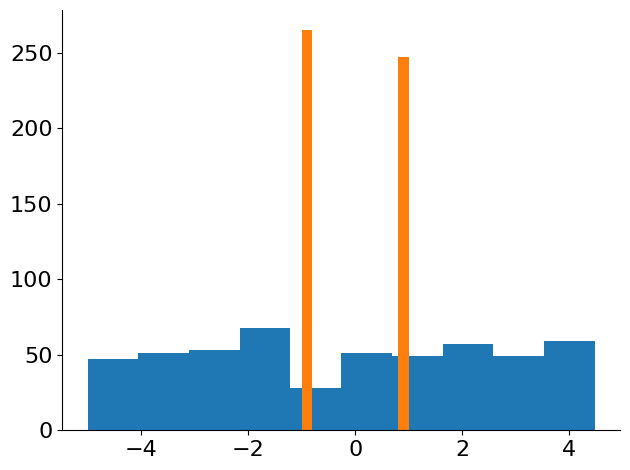

In [10]:
plt.hist(coherence[:, 0])
plt.hist(targets[:, -1])
plt.show()

In [11]:
idx_left = torch.argwhere(targets[:, -1] == -1).reshape(-1)[:32]
idx_right = torch.argwhere(targets[:, -1] == 1).reshape(-1)[:32]
print(idx_right.shape, idx_left.shape)

torch.Size([32]) torch.Size([32])


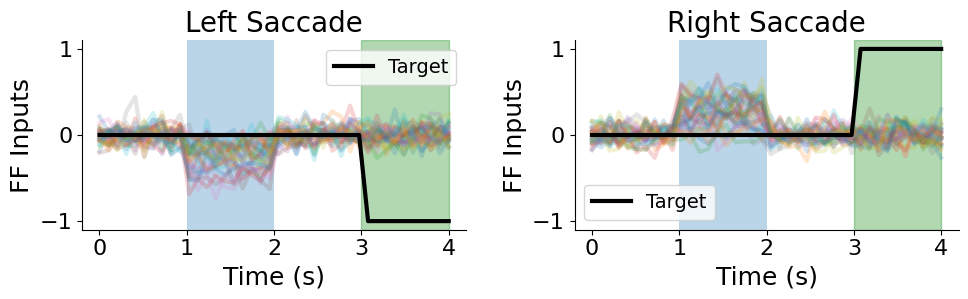

In [12]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, inputs[idx_left, :, 0].mT.cpu().numpy(), alpha=.2)
ax[0].plot(x_time, targets[idx_left[0]].cpu().numpy(), 'k', label='Target')
ax[0].set_title('Left Saccade')

ax[1].plot(x_time, inputs[idx_right, :, 0].mT.cpu().numpy(), alpha=.2)
ax[1].plot(x_time, targets[idx_right[0]].cpu().numpy(), 'k', label='Target')
ax[1].set_title('Right Saccade')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_ylim([-1.1, 1.1])
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('FF Inputs')
    ax[i].legend(fontsize=14)
plt.show()


Testing the naive network



In [13]:
predictions = model(inputs).squeeze((-1)).detach().cpu()
print('inputs', inputs.shape, 'predictions', predictions.shape)

inputs torch.Size([512, 40, 1]) predictions torch.Size([512, 40])


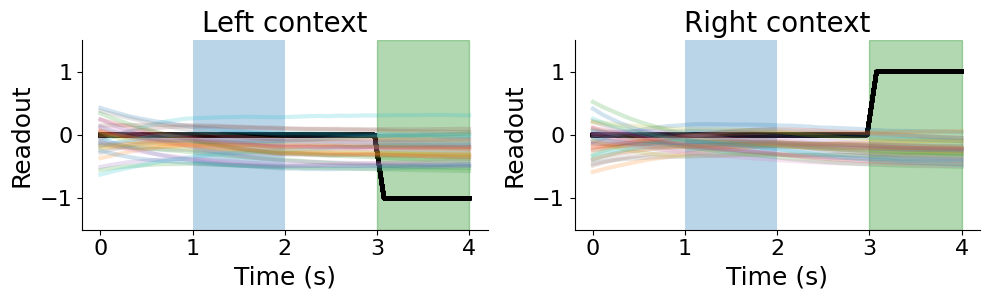

In [14]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, targets[idx_left].T, 'k')
ax[0].plot(x_time, predictions[idx_left].T, alpha=.2)
ax[0].set_title('Left context')

ax[1].plot(x_time, targets[idx_right].T, 'k')
ax[1].plot(x_time, predictions[idx_right].T, alpha=.2)
ax[1].set_title('Right context')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Readout")
    ax[i].set_ylim([-1.5, 1.5])
    # ax[i].legend(fontsize=14)

plt.show()

## Training the model



In [15]:
learning_rate = 0.05
epochs = 50
batch_size = 32

In [16]:
from torch.utils.data import DataLoader, TensorDataset

def optimization(model, X, Y, criterion, optimizer, mask=1, epochs=30, batch_size=32, bl=stim_offset, verbose=1):
    dataset = TensorDataset(X, Y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    loss_list = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in loader:

            output = model(batch_x).squeeze(-1)
            # compute errors in response window
            loss = criterion(output, batch_y) * mask
            loss = torch.mean(loss)
            # impose zero readout outside response window
            loss_bl = criterion(output[:, :bl], batch_y[:, :bl]*0) * (1-mask[:, :bl])
            loss += torch.mean(loss_bl)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        loss_list.append(total_loss)

        if (verbose) and (((epoch+1) % 5==0) or (epoch==epochs-1) or (epoch==0)):
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss:.4f}')

    return loss_list

In [17]:
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = optimization(model, inputs, targets, criterion, optimizer, mask, epochs)

Epoch 1/50, Training Loss: 0.3763
Epoch 5/50, Training Loss: 0.3405
Epoch 10/50, Training Loss: 0.0847
Epoch 15/50, Training Loss: 0.0812
Epoch 20/50, Training Loss: 0.0713
Epoch 25/50, Training Loss: 0.2216
Epoch 30/50, Training Loss: 0.0686
Epoch 35/50, Training Loss: 0.0422
Epoch 40/50, Training Loss: 0.0418
Epoch 45/50, Training Loss: 0.0534
Epoch 50/50, Training Loss: 0.1154


## Testing the model



In [18]:
# inputs, targets, mask, coherence = generate_rdm_trials(n_trials)
predictions = model(inputs).squeeze((-1)).detach().cpu()
print('inputs', inputs.shape, 'predictions', predictions.shape)

inputs torch.Size([512, 40, 1]) predictions torch.Size([512, 40])


In [19]:
idx_left = torch.argwhere(targets[:, -1] == -1).reshape(-1)
idx_right = torch.argwhere(targets[:, -1] == 1).reshape(-1)
print(idx_right.shape, idx_left.shape)

torch.Size([247]) torch.Size([265])


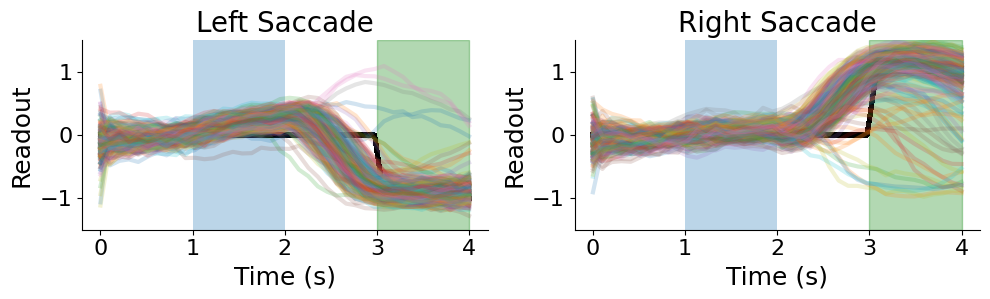

In [20]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, targets[idx_left].T, 'k')
ax[0].plot(x_time, predictions[idx_left].T, alpha=.2)
ax[0].set_title('Left Saccade')

ax[1].plot(x_time, targets[idx_right].T, 'k')
ax[1].plot(x_time, predictions[idx_right].T, alpha=.2)
ax[1].set_title('Right Saccade')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Readout")
    ax[i].set_ylim([-1.5, 1.5])
    # ax[i].legend(fontsize=14)

plt.show()

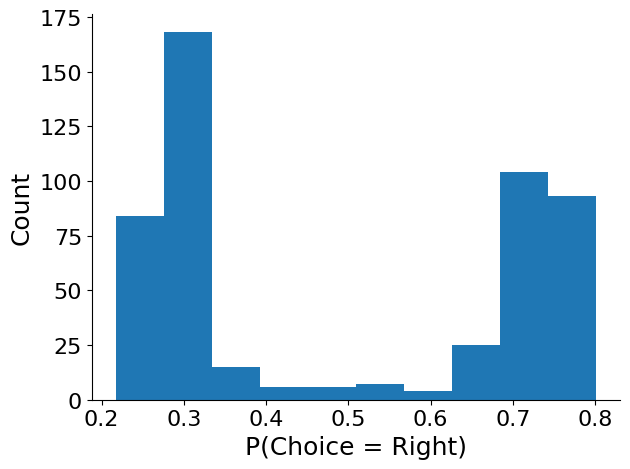

In [23]:
prob = torch.sigmoid(predictions[:, -1])
idx = torch.where(targets[:, -1]==1)

plt.hist(prob.cpu())
plt.xlabel('P(Choice = Right)')
plt.ylabel('Count')
plt.show()

Now we can look at the behavior of the network

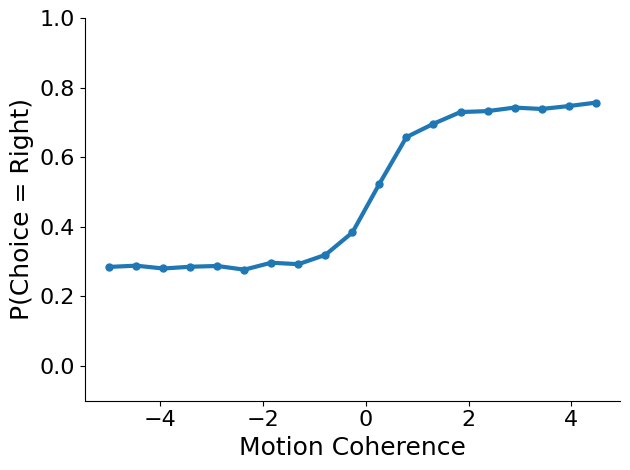

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming prob and coherences defined as above
bins = np.sort(np.unique(coherence[:,0]))
psychometric = [prob[coherence[:, 0] == c].mean().item() for c in bins]

plt.plot(bins, psychometric, 'o-')
plt.xlabel('Motion Coherence')
plt.ylabel('P(Choice = Right)')
plt.ylim([-0.1, 1])
plt.show()